In the introduction chapter we used a very straight-forward fitting algorithm - linear least squares - to find a regression function which could explain a dataset. We'll now look at some more advanced techniques which can give our models more flexibility, by considering the notion of _similarity_ in our data.

# Kernel Functions

In the previous example of linear regression we implicitly assume that all of the data can be describe with relation to a single functional form which describes the behaviour of the function over its entire parameter space, but in many situations we may not have access to enough information to determine such a global function, if one even exists. 

Instead, we can take the approach of determining how data which are somehow *close together* affect each other, and build our fit off this information.

Let's have a look at a concrete example.

In [1]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

import plotting
plt.style.use(plotting.blueprint)

/home/daniel/.virtualenvs/IGRlaptop21/teaching-stats/local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
size = 200

x = np.linspace(0, 1, size)
# y = a + b*x

def normal(x, mean, std):
    return np.exp(-(x-mean)**2/std**2)/std**2

true_regression_line = 0.3*normal(x,0.5,0.1) + 0.2*normal(x,0.25,0.1) + 0.2*normal(x,0.85,0.1) + 0.5*normal(x,0.65,0.1)
y = true_regression_line + np.random.normal(scale=.15, size=size)

data = dict(x=x, y=y)

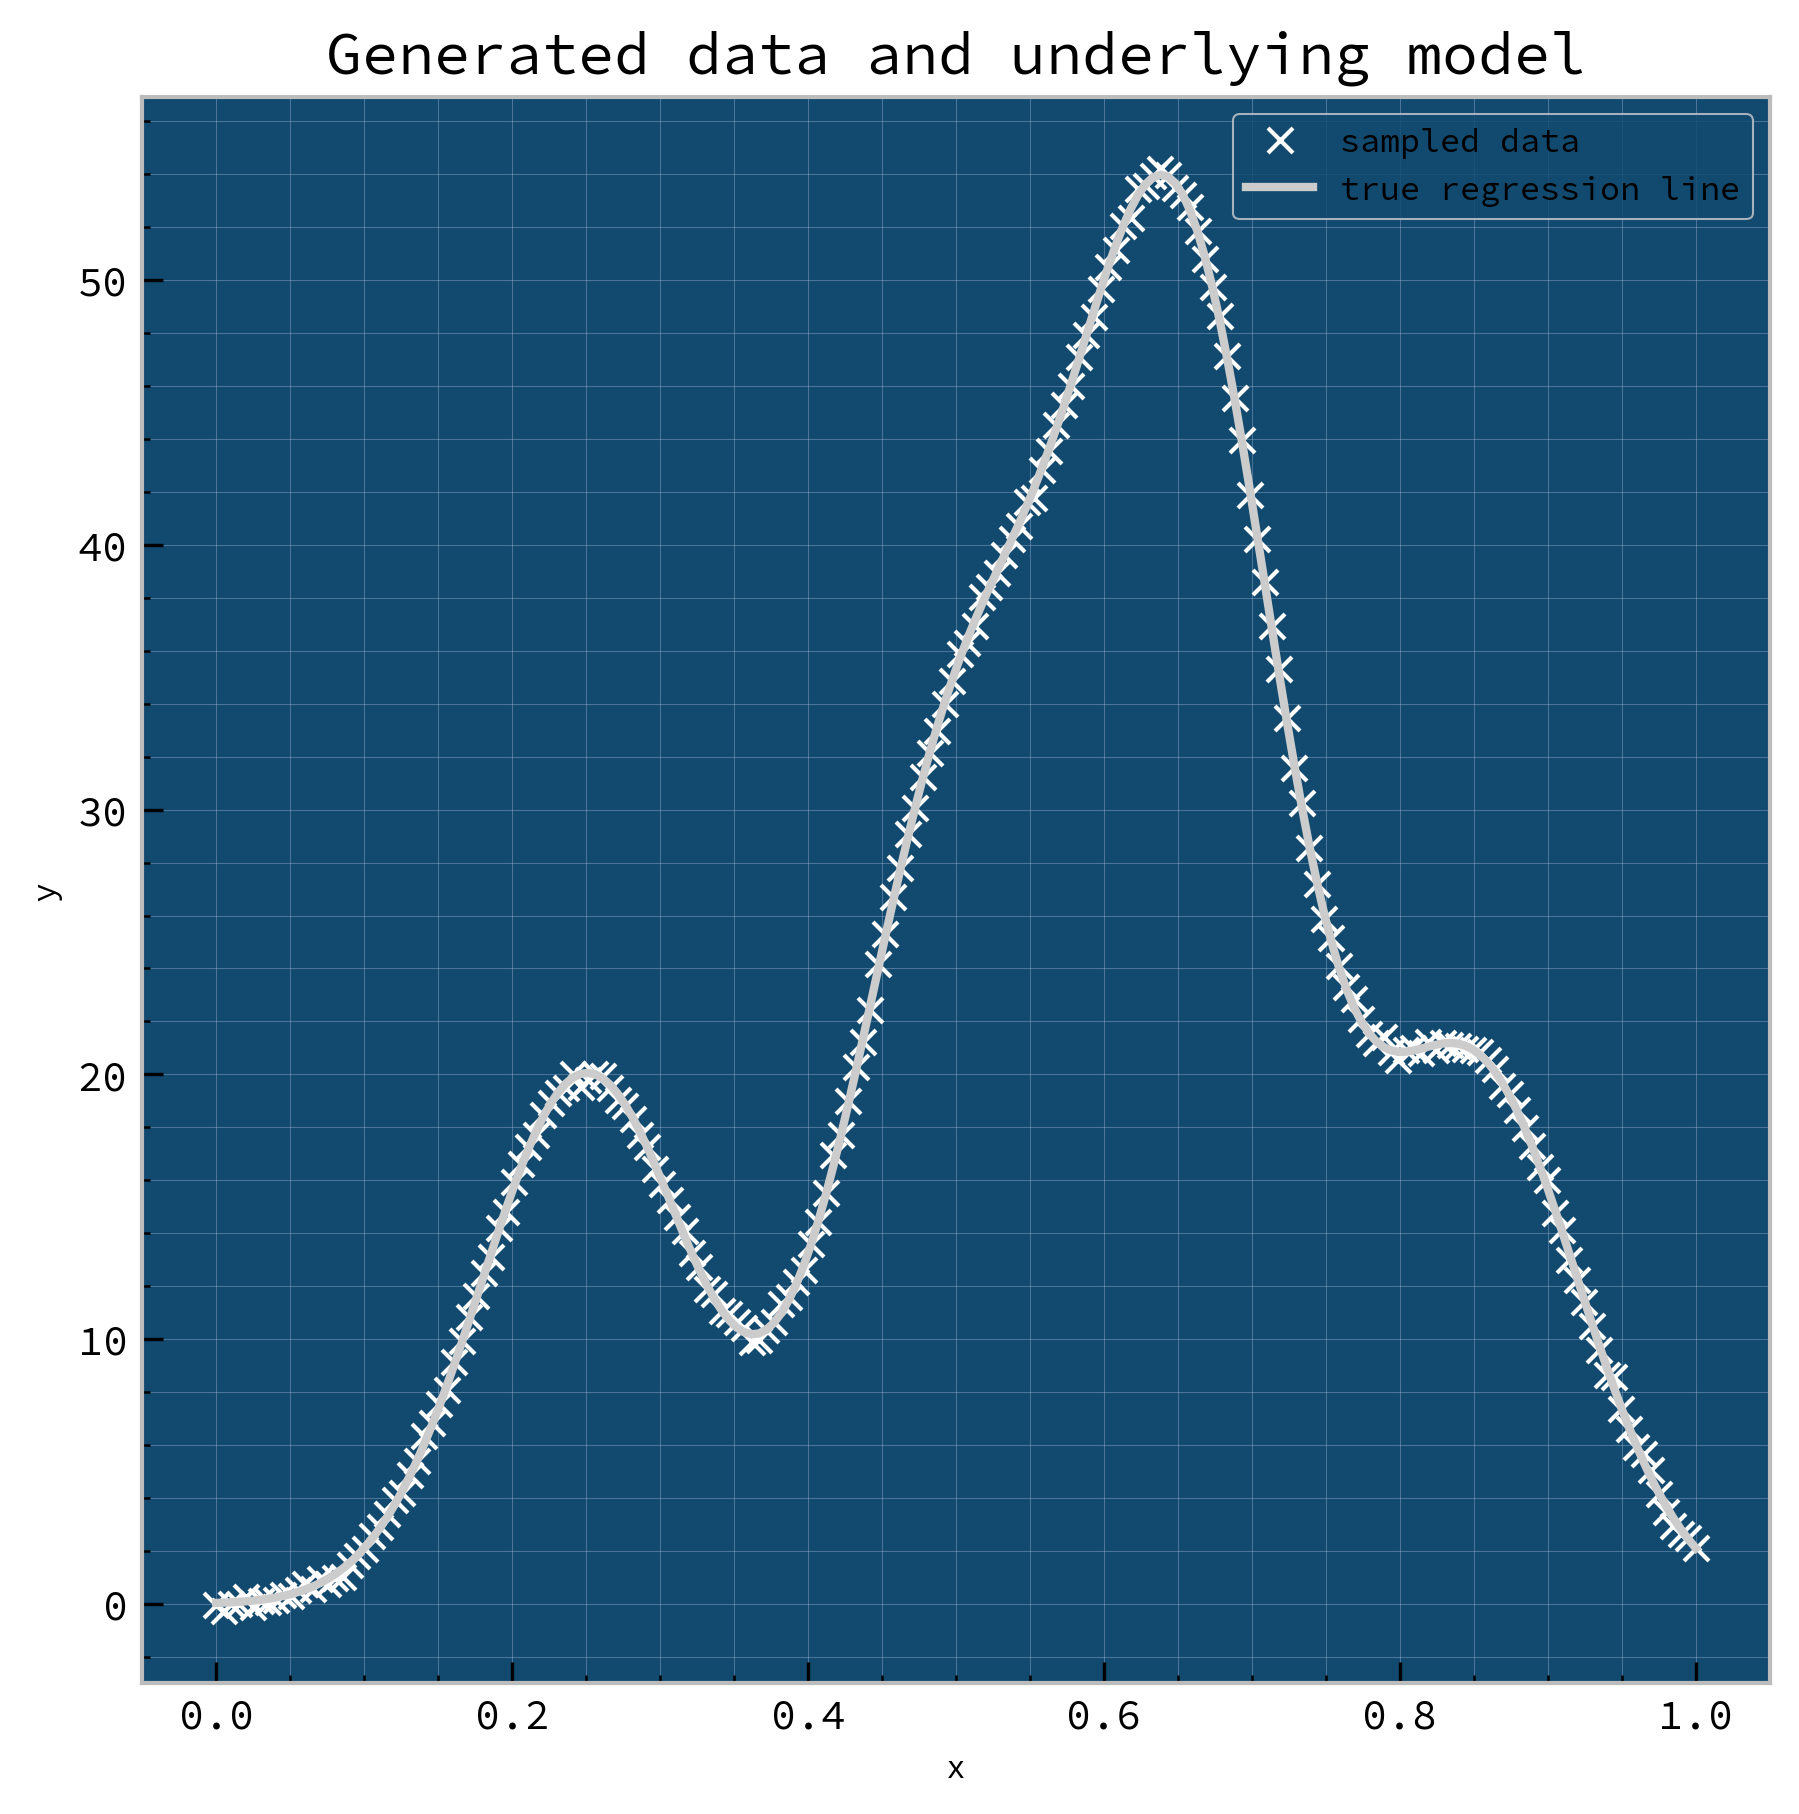

In [3]:
fig = plt.figure(figsize=(7, 7), dpi=300)
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The samples here are generated from a reasonably straightforward function; it's just the sum of four normal distributions. However, the resulting function looks complicated, and it's not immediately clear what function we'd try to fit to this. What we can tell is that the data varies smoothly over the parameter space, and the point on either side of any given point  tends to have a fairly similar value to its neighbour. 

To get started down this road we can think of the $x$ values of our data as existing in a space we'll call the "data space". We can apply some mapping $\phi: \mathbb{R} \to \mathbb{R}, x \to \phi(x)$ which converts the values in data space to values in a new vector space (specifically, an inner product space) we'll call the feature space. If we make a good choice of feature space, then we should be able to find a fairly straight-forward fit to our transformed data.

A popular choice of mapping takes the functional form of an exponential, for example:

\\[ \phi(x) = \exp(-x^2 / (2 \sigma^2) ).\\]

Let's have a look at what this does to our function.

In [4]:
def mapping(x, length_scale=1):
    return np.exp(-x**2/(2*length_scale**2))

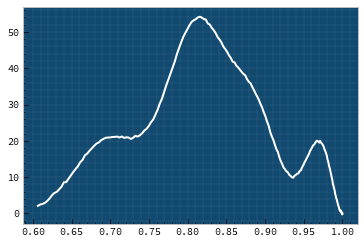

In [5]:
plt.plot(mapping(x), y)

Well, there's been some change, but it's not really helping a lot. Looking at the expression for $\phi$, however, we notice that there's a $\sigma$ term. This lets us _tune_ our kernel. Let's have a look at what happens when we try different values of $\sigma$.

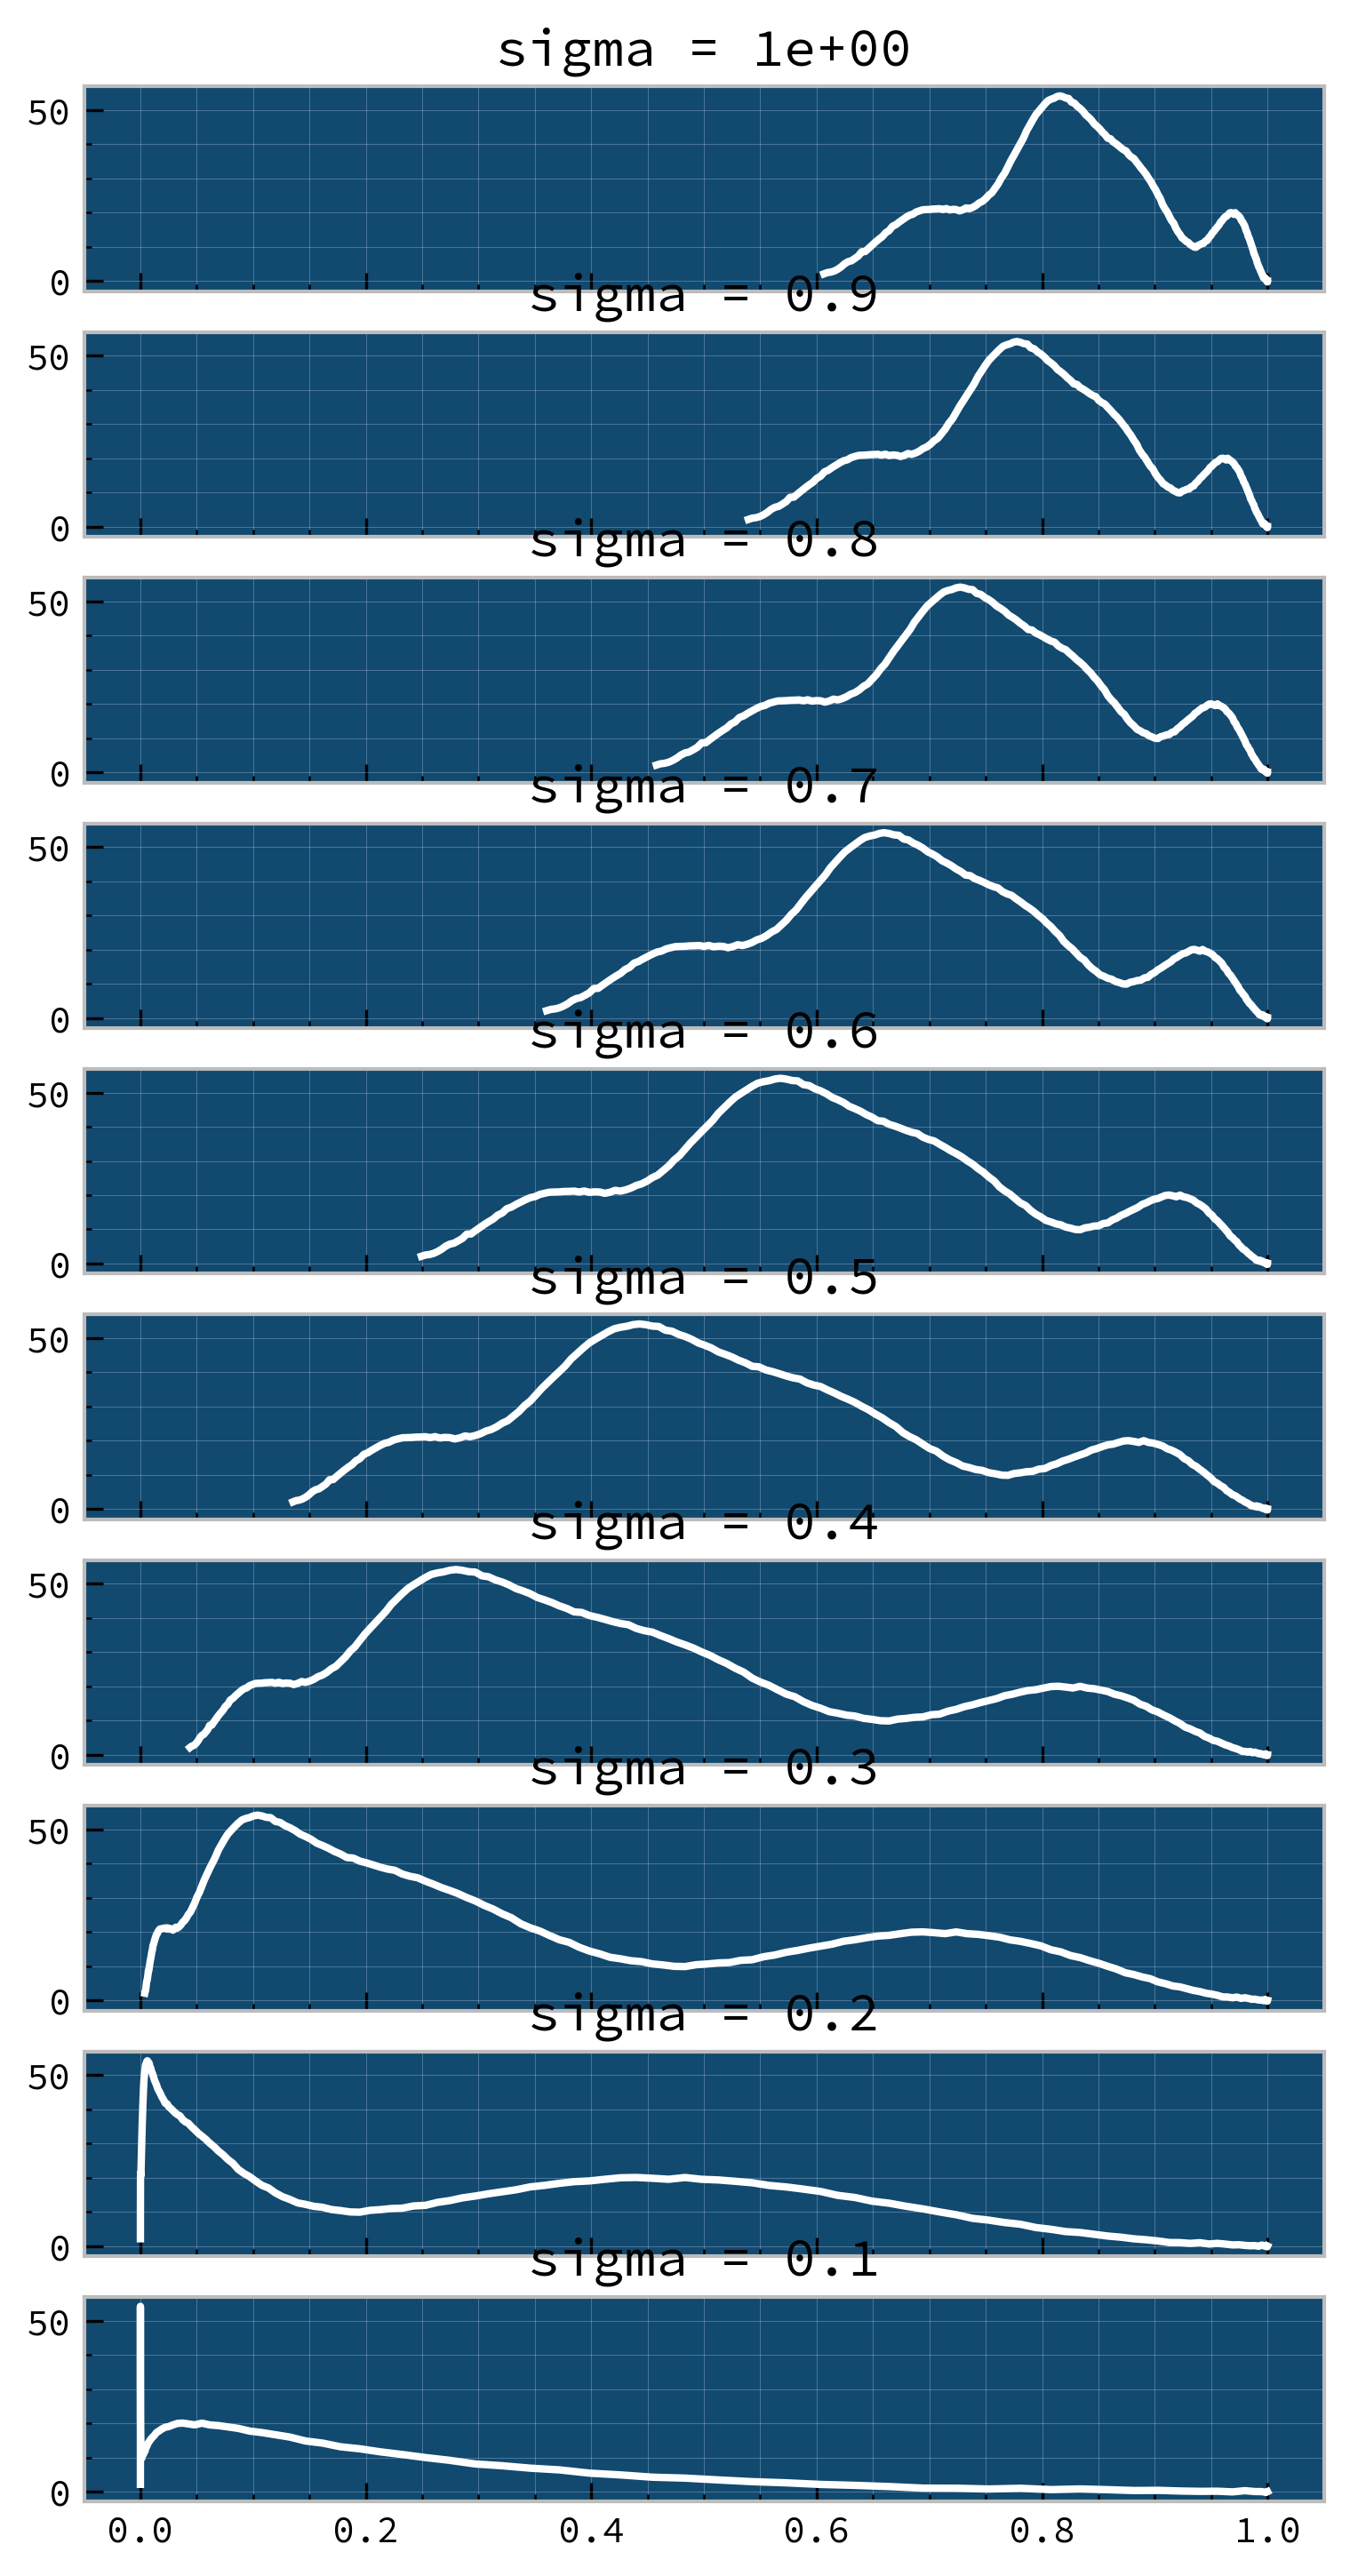

In [6]:
f, ax = plt.subplots(10,1, figsize=(6,12), dpi=300, sharex=True);

for i in range(10):
    ax[i].plot(mapping(x, length_scale = 1-(0.1*i)), y)
    ax[i].set_title("sigma = {:.0}".format(1-(0.1*i)))

As we make the sigma parameter, which we can think of as a _length-scale_, of the mapping smaller, we move towards something which looks more and more like a simple function. However, if we now find a fit to this new simpler function, and try to map back to the original data space we find that things just don't work.

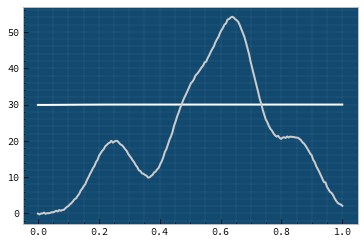

In [7]:
x = np.linspace(0,1, 100)
y = -0.1 * mapping(x, 0.1) +30
plt.plot(x, y)

plt.plot(data['x'], data['y'])

In order to have a working regression technique which works in feature space we need to move from mapping the data into feature space to mapping the distances between the points. We can now see why the mapping is really helpful: it provides a function with a fairly constant gradient across the feature space, so neighbouring points are closely connected in the feature space. 

We can use this to define a distance measure in our feature space:

\\[ d(x_1,x_2) =  \phi(x_1) - \phi(x_2) = \exp(-x_1^2 / (2 \sigma^2) ) -  \exp(-x_2^2 / (2 \sigma^2) ) =   \exp(-(x_1^2 - x_2^2) / (2 \sigma^2) )\\]

We can use this distance measure to define the covariance of the data, that is, how similar we expect each point to be to every other point in the dataset. Let's have a look at what this looks like for the exponential example above.

In [8]:
def exponential_squared(x1, x2, length_scale = 1):
    return np.exp(-(x1-x2)**2/2*length_scale)

In [9]:
K = np.zeros((len(x),len(x)))
for i, xd in enumerate(x):
    for j, yd in enumerate(x):
        K[i,j] = exponential_squared(xd,yd,0.1)

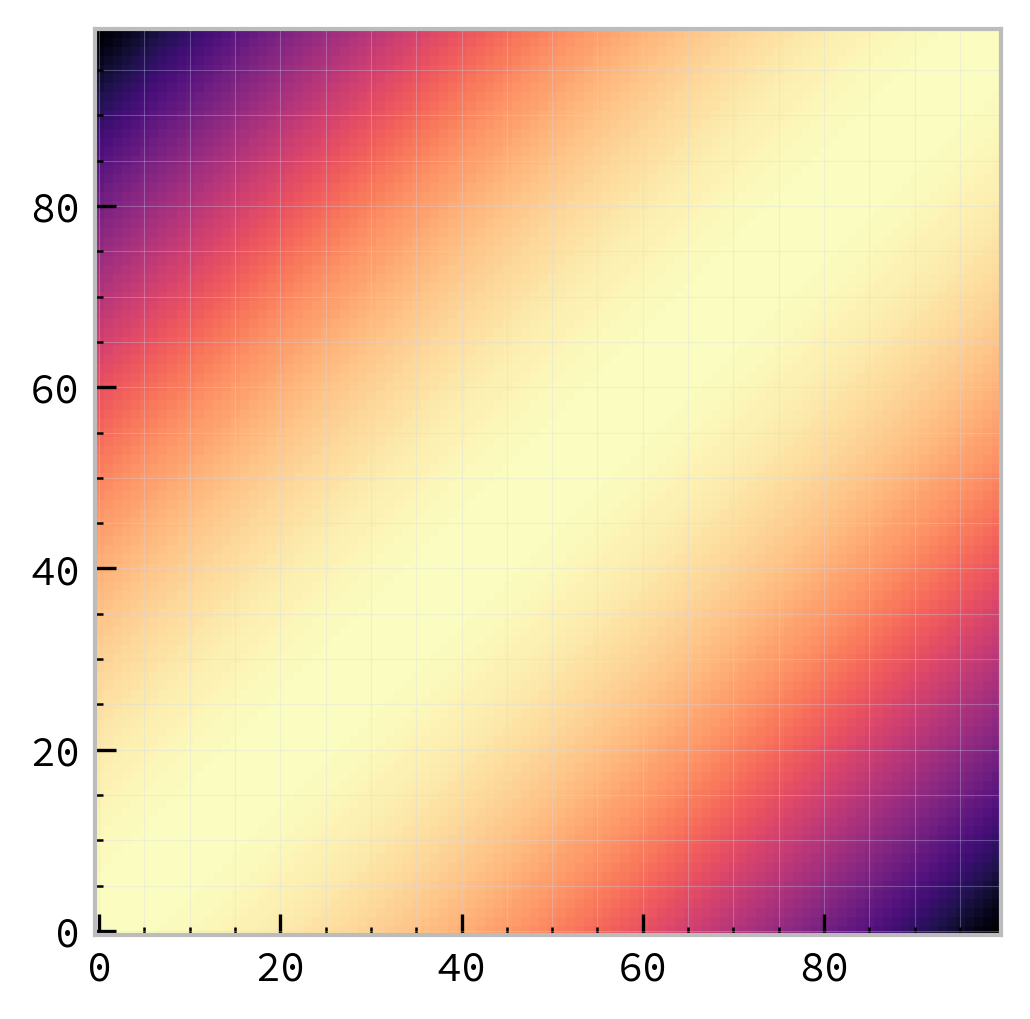

In [14]:
f, ax = plt.subplots(1,1, dpi=300)
ax.imshow(K, cmap="magma", origin="lower");

This distance measure is called a "kernel" or a covariance function, and they allow us to use the relationships within a dataset without considering the data's relation to any external reference for inference.

Kernel methods are an important family of algorithms within Bayesian statistics and machine learning, and they're central to to workings of Gaussian processes. 

## Other covariance functions

We've met the exponential squared covariance function now, but what other covariance functions could we use? `pymc3` supports a fairly large number of potential covariance functions (see the great page of documentation [here](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html)). We can use the covariance function to encode our prior belief about the general types of function which will describe our data. For example, if there is a periodicity in our data we would expect that points separated by a period from each other would be closely related, and therefore should be mapped close together in feature space. Conversely, if our data looks like a Brownian process then close-together points might map to being far apart in the feature space. 